# Multi-timescale differentiation in Transformer attention
In this notebook we examine differences in attention patterns of a Transformer model processing scrambled vs. non-scrambled texts. We create texts scrambled at several different levels inspired by the Temporal Receptive Window hierarchy of [Lerner et al. (2011)](https://www.jneurosci.org/content/31/8/2906). For each level we compare attention head behaviours when the model processes the original text vs. scrambled text, using median k-value and mean weighted average distance measures.

The notebook benefits from a collaboration with Marianne de Heer Kloots' work.

In [1]:
#@title packages and settings { vertical-output: true }
!pip install -q transformers plotnine

import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer

import pandas as pd
import seaborn as sns
from scipy.stats import rankdata
import matplotlib
import itertools
import random

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
# uncomment this if you run into memory issues on the gpu
device = torch.device("cpu")

In [2]:
#@title AHviz
# make the dimension indices of the array explicit as
# a pandas dataframe MultiIndex
def create_indices(att:np.ndarray, names:list=['layer', 'head', 'sample', 'from_token', 'to_token'], **kwargs):
    """
    Build a pandas MultiIndex for a huggingface transformers attention matrix
    """
    spec = att.shape
    dims = {}
    for dim, size in reversed(list(enumerate(spec))):
        start = 0
        if names[dim] in kwargs:
            start = kwargs[names[dim]]
        if dim == len(spec) - 1:
            dims[dim] = np.arange(start, start + size) + 1
        else:
            for d in range(dim + 1, len(spec)):
                dims[d] = np.tile(dims[d], size)
            dims[dim] = np.repeat(np.arange(start, start + size) + 1, np.prod(spec[dim+1:]))

    return pd.MultiIndex.from_arrays(
            list(dims.values()),
            names=reversed(names)
        )

def create_dataframe(att:torch.Tensor, ix:pd.MultiIndex):
    df = pd.DataFrame(
            att.flatten(), # turn the array into one long list of numbers
            columns=["attention_fraction"],
            index=ix, # indexed by its dimensions
        ).reset_index() # and then turn the dimensions into columns
    return df

def filter_mask(df:pd.DataFrame, mask:torch.Tensor, how="both"):
    # filter out the masked tokens
    for sample in range(df['sample'].max()):
    #for sentence, toklist in enumerate(mask.tolist()):
#        # the next two lines filter out the first and last unmasked token which are [CLS] and [SEP] (for bert)
#        # comment them out to see the results with them included
#        final = max(np.nonzero(toklist)[0])
#        modified = [0] + toklist[1:final] + [0] + toklist[final+1:]

        for token in [i for i, v in enumerate(mask) if v == 0]:
            if how == "both":
                query = f"~(sample == {sample + 1} & (to_token == {token + 1} | from_token == {token + 1}))"
            else:
                query = f"~(sample == {sample + 1} & ({how}_token == {token + 1})"
            print(query)
            df = df.query(query)

In [3]:
#@title scrambling functions
def allnonalnum(token):
  """
  This function checks if all characters in a cell are non-alphanumeric (in which
  case we assume it's a punctuation).
  """
  return all(not c.isalnum() for c in list(token))

def attach_tokens(idx, wp, token_column):
  """
  This function merges one or multiple punctuation tokens and attaches them to the
  nearest preceding or following word (according to the wp annotation).
  """

  if wp == 'w_p_pre':
    # look at preceding tokens
    next = -1
  elif wp == 'w_p_fol':
    # look at following tokens
    next = 1

  while pd.isnull(token_column[idx[-1]]) or allnonalnum(token_column[idx[-1]]):
    # collect tokens until we find a word
    idx.append(idx[-1] + next)

  if wp == 'w_p_pre':
    # reverse indices if we were looking backwards
    idx.reverse()

  # remove empty cells and make list
  token_list = list(token_column.loc[idx].dropna())

  # merge all collected tokens together
  merged_tokens = ''.join(token_list)

  return idx, merged_tokens

def merge_wordpuncs(tokens_series, word_punctuation_column):
  """
  This function goes through a series of tokens which contain punctuations
  at indices marked in the word_punctuation_column, and merges words with preceding
  or following punctuations (according to the annotation).
  """
  # list of row indices that have wordpunc annotations
  wordpunc_idx = list(word_punctuation_column.dropna().index)
  merged_tokens = tokens_series.copy()

  for tok_idx, token in tokens_series.items():
    # for any non-empty cell where all characters are non-alphanumeric
    if (not pd.isnull(token)) and allnonalnum(token):
      # look for wordpunc annotation, if none assume 'w_p_pre'
      wp = word_punctuation_column.loc[tok_idx] if tok_idx in wordpunc_idx else 'w_p_pre'
      # merge token with preceding/following tokens accordingly
      idx, merged_token = attach_tokens([tok_idx], wp, tokens_series)
      # replace the first of the old tokens by the new merged token
      merge_start = idx[0]
      merged_tokens[merge_start] = merged_token
      # and remove the rest
      merged_tokens[idx[1:]] = np.nan

  # remove empty cells and return list
  return list(merged_tokens.dropna())

def reverse_characters(token_column, word_punctuation_column):
  """
  This function reverses all characters in the text and returns a token list of
  the reversed text.
  """
  # attach punctuations to words
  merged_tokens = merge_wordpuncs(token_column, word_punctuation_column)

  # merge tokens to string & reverse string
  reversed_text = ' '.join(merged_tokens)[::-1]

  # return reversed text as token list
  return reversed_text.split(' ')

def shuffle_words_with_punc(token_column, word_punctuation_column):
  """
  This function shuffles words together with their attached punctuations.
  The punctuations are attached first, according to annotations in the
  word_punctuations column.
  """
  # attach punctuations to words
  merged_tokens = merge_wordpuncs(token_column, word_punctuation_column)
  # shuffle merged tokens
  random.shuffle(merged_tokens)

  return merged_tokens

def shuffle_words_punc_fixed(token_column, punctuation_column, word_punctuation_column):
  """
  This function shuffles all cells in the token column except for the cells annotated
  as punctuations (i.e. keeping punctuations fixed). It shuffles all non-punctuation
  tokens, then reinserts punctuation tokens, and then merges punctuation to preceding/
  following words according to word_punctuation annotations.
  """
  # list of row indices that have punctuation annotations
  puncs_idx = punctuation_column.dropna().index
  # the punctuation tokens
  puncs_tokens = token_column[puncs_idx]
  # all tokens except the punctuation tokens
  tokens_without_punc = np.array(token_column[~token_column.index.isin(puncs_idx)].values)

  # shuffle the non-punctuation tokens
  random.shuffle(tokens_without_punc)

  # re-insert the punctuation tokens at their original indices
  tokens_with_punc = tokens_without_punc.copy()
  for idx, punc in puncs_tokens.iteritems():
    tokens_with_punc = np.insert(tokens_with_punc, idx, punc)

  # attach punctuations to words
  tokens_with_punc = pd.Series(tokens_with_punc)
  merged_tokens = merge_wordpuncs(tokens_with_punc, word_punctuation_column)

  return merged_tokens

def shuffle_sentences(token_column, sentences_column, word_punctuation_column,
                      scramble_subsentences=True):
  """
  This function shuffles the text at the sentence level, taking sentences as
  annotated in the sentences column.
  """
  # subsentences also get scrambled (the function matches cells that contain 'BOS' and 'EOS' rather than cells that are exactly equal to 'BOS' or 'EOS')
  if scramble_subsentences:
    # find indices of all sentence beginning and end annotations (incl. subsentences)
    bos_idx = list(np.where(sentences_column.str.contains('BOS') == True)[0])
    eos_idx = list(np.where(sentences_column.str.contains('EOS') == True)[0])
  else:
    # find indices of main sentence beginning and end annotations
    bos_idx = list(sentences_column[sentences_column == "BOS"].index)
    eos_idx = list(sentences_column[sentences_column == "EOS"].index)

  # get all tokens between each 'BOS' and 'EOS' annotation
  sentence_series = [token_column[bos:eos+1]
                for bos, eos in zip(bos_idx, eos_idx)]

  sentence_strings = []
  for sentence in sentence_series:
    # attach punctuations to words
    ## M: for debugging
    ## print(sentence)
    merged_wp_sent = merge_wordpuncs(sentence, word_punctuation_column)
    # make string and add sentence to list
    sentence_strings.append(' '.join(merged_wp_sent))

  # shuffle list of sentence strings
  random.shuffle(sentence_strings)

  return sentence_strings

def shuffle_paragraphs(token_column, paragraphs_column, word_punctuation_column):
  """
  This function shuffles the text at the paragraph level, taking paragraphs as
  annotated in the paragraphs column.
  """
  # find indices of paragraph beginning and end annotations
  bop_idx = list(paragraphs_column[paragraphs_column == "BOP"].index)
  eop_idx = list(paragraphs_column[paragraphs_column == "EOP"].index)

  # get all tokens between each 'BOP' and 'EOP' annotation
  paragraph_series = [token_column[bop:eop+1]
                for bop, eop in zip(bop_idx, eop_idx)]

  paragraph_strings = []
  for paragraph in paragraph_series:
    # attach punctuations to words
    merged_wp_par = merge_wordpuncs(paragraph, word_punctuation_column)
    # make string and add paragraph to list
    paragraph_strings.append(' '.join(merged_wp_par))

  # shuffle list of paragraph strings
  random.shuffle(paragraph_strings)

  return paragraph_strings

In [4]:
#@title load transformer & tokenizer { vertical-output: true }
#transformer = "bert-base-cased"
#transformer = "gpt2"
transformer = "gpt2-medium"
#transformer = "gpt2-large" #@param
#transformer = "twmkn9/bert-base-uncased-squad2"
#transformer = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(transformer)

# gpt2 doesn't do padding, so invent a padding token
# this one was suggested by the error you get when trying
# to do masking below, but it shouldn't matter as the actual
# tokens get ignored by the attention mask anyway
if "gpt2" in transformer:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModel.from_pretrained(transformer,
                                  output_attentions=True,
                                  output_hidden_states=False)
model.to(device)
model.eval()
model.zero_grad()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

## Creating scrambled texts
We create scrambled .txt files for the Harry Potter chapter according to the annotations in the spreadsheet linked below.
We create text files with these conditions:
- **reversed text:** the entire text is reversed at the character level
- **scrambled paragraphs:** the text is scrambled at the paragraph level
- **scrambled sentences:** the text is scrambled at the sentence level
- **scrambled words, fixed punctuations:** the text is scrambled at the word level, with punctuations in the same fixed order (and similar position) as in the original text
- **scrambled words, with punctuations:** the text is scrambled at the word level, with punctuations attached to preceding or following words before scrambling

In [5]:
#ch 16 vs exp
annotations_csv = "https://github.com/Lucia2323/Attention-visualization-methods_Transformers/raw/main/HP1_ch16_condition%20annotations.csv"
#use raw link on github

cutoff_line = 7940 #@param
## changed from 7942 to end at last sentence before riddle (7940)
## (see end of edited tokens column below)

#ch 9
#annotations_csv = "https://github.com/Lucia2323/Attention-visualization-methods_Transformers/raw/main/HP_ch9.csv"
#cutoff_line = 456

#half1 vs half2
#annotations_csv = "https://github.com/Lucia2323/Attention-visualization-methods_Transformers/raw/main/Half_1_HP1_ch16_condition%20annotations.csv"
#annotations_2_csv = "https://github.com/Lucia2323/Attention-visualization-methods_Transformers/raw/main/Half_2_HP1_ch16_condition%20annotations.csv" #@param

#cutoff_line = 3970

In [6]:
# ch 16 load annotations into dataframe & print edit counts
annotations_df = pd.read_csv(annotations_csv)
annotations_df = pd.read_csv(annotations_csv, on_bad_lines='skip')
annotations_df = annotations_df[annotations_df.index.astype(str).str.isnumeric()]
annotations_df = annotations_df.set_index(annotations_df.index.astype(int))
annotations_df = annotations_df.loc[:cutoff_line]


print('# deleted tokens:', annotations_df['deleted tokens'].count())
print('# added tokens:', annotations_df['added tokens'].count())
print('# replaced tokens:', annotations_df['added tokens'].count())
annotations_df

# deleted tokens: 552
# added tokens: 249
# replaced tokens: 249


,original tokens,Unnamed: 1,edited tokens,deleted tokens,added tokens,replaced tokens,sentences,paragraphs,punctuations,word_punctuation,character names,place names,special words
0,In,NaN,In,NaN,NaN,NaN,BOS,BOP,NaN,NaN,NaN,NaN,NaN
1,years,NaN,years,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,to,NaN,to,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,come,NaN,come,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,",",NaN,",",NaN,NaN,NaN,NaN,NaN,comma,w_p_pre,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7936,a,NaN,.,NaN,NaN,NaN,EOS,NaN,p,w_p_pre,NaN,NaN,NaN
7937,puzzle,NaN,They,NaN,NaN,NaN,BOS,NaN,NaN,NaN,NaN,NaN,NaN
7938,.,NaN,were,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7939,A,NaN,trapped,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# half1vshalf2 load annotations into dataframe & print edit counts
#annotations_df = pd.read_csv(annotations_csv)
#annotations_df = annotations_df.loc[:cutoff_line]

#annotations_df_2 = pd.read_csv(annotations_2_csv)
#annotations_df_2 = annotations_df_2.loc[:cutoff_line]

#print('# deleted tokens:', annotations_df['deleted tokens'].count())
#print('# added tokens:', annotations_df['added tokens'].count())
#print('# replaced tokens:', annotations_df['added tokens'].count())
#annotations_df

#print('# deleted tokens:', annotations_df_2['deleted tokens'].count())
#print('# added tokens:', annotations_df_2['added tokens'].count())
#print('# replaced tokens:', annotations_df_2['added tokens'].count())
#annotations_df_2

In [8]:
# ch16 columns needed for scrambling
token_column = annotations_df['edited tokens']
punctuation_column = annotations_df['punctuations']
word_punctuation_column = annotations_df['word_punctuation']
paragraphs_column = annotations_df['paragraphs']
sentences_column = annotations_df['sentences']

In [ ]:
# half1vshalf2 columns needed for scrambling
#token_column = annotations_df['edited tokens']
#punctuation_column = annotations_df['punctuations']
#word_punctuation_column = annotations_df['word_punctuation']
#paragraphs_column = annotations_df['paragraphs']
#sentences_column = annotations_df['sentences']

#token_column_2 = annotations_df_2['edited tokens']
#punctuation_column_2 = annotations_df_2['punctuations']
#word_punctuation_column_2 = annotations_df_2['word_punctuation']
#paragraphs_column_2 = annotations_df_2['paragraphs']
#sentences_column_2 = annotations_df_2['sentences']

In [9]:
#to check a token or line
annotations_df.loc[356]

original tokens      of
Unnamed: 1          NaN
edited tokens        of
deleted tokens      NaN
added tokens        NaN
replaced tokens     NaN
sentences           NaN
paragraphs          NaN
punctuations        NaN
word_punctuation    NaN
character names     NaN
place names         NaN
special words       NaN
Name: 356, dtype: object

In [ ]:
# ch16 do scrambling
random.seed(898765) #random seed of the current scrambled versions: 898765
original_text = merge_wordpuncs(token_column, word_punctuation_column)
reversed_text = reverse_characters(token_column, word_punctuation_column)
scrambled_words_fixpunc = shuffle_words_punc_fixed(token_column, punctuation_column, word_punctuation_column)
scrambled_words_withpunc = shuffle_words_with_punc(token_column, word_punctuation_column)
scrambled_paragraphs = shuffle_paragraphs(token_column, paragraphs_column, word_punctuation_column)

In [ ]:
scrambled_sentences = shuffle_sentences(token_column, sentences_column, word_punctuation_column, scramble_subsentences=True)

In [ ]:
# half1vshalf2 do scrambling
#random.seed(898765) #random seed of the current scrambled versions: 898765
#original_text = merge_wordpuncs(token_column, word_punctuation_column)
#reversed_text = reverse_characters(token_column, word_punctuation_column)
#scrambled_words_fixpunc = shuffle_words_punc_fixed(token_column, punctuation_column, word_punctuation_column)
#scrambled_words_withpunc = shuffle_words_with_punc(token_column, word_punctuation_column)
#scrambled_paragraphs = shuffle_paragraphs(token_column, paragraphs_column, word_punctuation_column)

#original_text_2 = merge_wordpuncs(token_column_2, word_punctuation_column_2)
#reversed_text_2 = reverse_characters(token_column_2, word_punctuation_column_2)
#scrambled_words_fixpunc_2 = shuffle_words_punc_fixed(token_column_2, punctuation_column_2, word_punctuation_column_2)
#scrambled_words_withpunc_2 = shuffle_words_with_punc(token_column_2, word_punctuation_column_2)
#scrambled_paragraphs_2 = shuffle_paragraphs(token_column_2, paragraphs_column_2, word_punctuation_column_2)

In [ ]:
#scrambled_sentences = shuffle_sentences(token_column, sentences_column, word_punctuation_column, scramble_subsentences=True)

#scrambled_sentences_2 = shuffle_sentences(token_column_2, sentences_column_2, word_punctuation_column_2, scramble_subsentences=True)

In [12]:
# ch16 print number of items scrambled & joined text
print('original txt', len(original_text), '\t', ' '.join(original_text))
print('reversed txt', len(reversed_text), '\t', ' '.join(reversed_text))
print('fixed punctuation scrambling:\t', len(scrambled_words_fixpunc), '\t', ' '.join(scrambled_words_fixpunc))
print('wordpunc scrambling:\t\t', len(scrambled_words_withpunc), '\t', ' '.join(scrambled_words_withpunc))
print('sentence scrambling:\t\t', len(scrambled_sentences), '\t', ' '.join(scrambled_sentences))
print('paragraphs scrambling:\t\t', len(scrambled_paragraphs), '\t', ' '.join(scrambled_paragraphs))

original txt 5807 	 In years to come, Harry would never quite remember how he had managed to get through his exams when he half expected Voldemort to come bursting through the door at any moment. Yet the days crept by, and there could be no doubt that Fluffy was still alive and well behind the locked door. It was sweltering hot, especially in the large classroom where they did their written papers. They had been given special, new quills for the exams, which had been bewitched with an Anticheating spell. They had practical exams as well. Professor Flitwick called them one by one into his class to see if they could make a pineapple tapdance across a desk. Professor McGonagall watched them turn a mouse into a snuffbox— points were given for how pretty the snuffbox was, but taken away if it had whiskers. Snape made them all nervous, breathing down their necks while they tried to remember how to make a Forgetfulness potion. Harry did the best he could, trying to ignore the stabbing pains i

In [ ]:
# half1vshalf2 print number of items scrambled & joined text
#print('original txt', len(original_text), '\t', ' '.join(original_text))
#print('reversed txt', len(reversed_text), '\t', ' '.join(reversed_text))
#print('fixed punctuation scrambling:\t', len(scrambled_words_fixpunc), '\t', ' '.join(scrambled_words_fixpunc))
#print('wordpunc scrambling:\t\t', len(scrambled_words_withpunc), '\t', ' '.join(scrambled_words_withpunc))
#print('sentence scrambling:\t\t', len(scrambled_sentences), '\t', ' '.join(scrambled_sentences))
#print('paragraphs scrambling:\t\t', len(scrambled_paragraphs), '\t', ' '.join(scrambled_paragraphs))

#print('original txt_2', len(original_text_2), '\t', ' '.join(original_text_2))
#print('reversed txt_2', len(reversed_text_2), '\t', ' '.join(reversed_text_2))
#print('fixed punctuation scrambling:\t_2', len(scrambled_words_fixpunc_2), '\t', ' '.join(scrambled_words_fixpunc_2))
#print('wordpunc scrambling:\t\t_2', len(scrambled_words_withpunc_2), '\t', ' '.join(scrambled_words_withpunc_2))
#print('sentence scrambling:\t\t_2', len(scrambled_sentences_2), '\t', ' '.join(scrambled_sentences_2))
#print('paragraphs scrambling:\t\t_2', len(scrambled_paragraphs_2), '\t', ' '.join(scrambled_paragraphs_2))

original txt 2910 	 In years to come, Harry would never quite remember how he had managed to get through his exams when he half expected Voldemort to come bursting through the door at any moment. Yet the days crept by, and there could be no doubt that Fluffy was still alive and well behind the locked door. It was sweltering hot, especially in the large classroom where they did their written papers. They had been given special, new quills for the exams, which had been bewitched with an Anticheating spell. They had practical exams as well. Professor Flitwick called them one by one into his class to see if they could make a pineapple tapdance across a desk. Professor McGonagall watched them turn a mouse into a snuffbox— points were given for how pretty the snuffbox was, but taken away if it had whiskers. Snape made them all nervous, breathing down their necks while they tried to remember how to make a Forgetfulness potion. Harry did the best he could, trying to ignore the stabbing pains i

In [13]:
# ch16 save scrambled texts to files

# filenames & strings
fn_scrambled_str = [('original_text.txt', ' '.join(original_text)),
 ('reversed_text.txt', ' '.join(reversed_text)),
 ('scrambled_words_fixpunc.txt', ' '.join(scrambled_words_fixpunc)),
 ('scrambled_words_withpunc.txt', ' '.join(scrambled_words_withpunc)),
 ('scrambled_sentences.txt', ' '.join(scrambled_sentences)),
 ('scrambled_paragraphs.txt', ' '.join(scrambled_paragraphs))]

 # write to files
for fn, scrambled_str in fn_scrambled_str:
  with open(fn, 'w') as f:
      f.write(scrambled_str)
      f.close()

In [ ]:
# half1vshalf2 save scrambled texts to files

# filenames & strings
#fn_scrambled_str = [('original_text.txt', ' '.join(original_text)),
# ('reversed_text.txt', ' '.join(reversed_text)),
# ('scrambled_words_fixpunc.txt', ' '.join(scrambled_words_fixpunc)),
# ('scrambled_words_withpunc.txt', ' '.join(scrambled_words_withpunc)),
# ('scrambled_sentences.txt', ' '.join(scrambled_sentences)),
# ('scrambled_paragraphs.txt', ' '.join(scrambled_paragraphs))]

#fn_scrambled_str_2 = [('original_text.txt_2', ' '.join(original_text_2)),
# ('reversed_text.txt_2', ' '.join(reversed_text_2)),
# ('scrambled_words_fixpunc.txt_2', ' '.join(scrambled_words_fixpunc_2)),
# ('scrambled_words_withpunc.txt_2', ' '.join(scrambled_words_withpunc_2)),
# ('scrambled_sentences.txt_2', ' '.join(scrambled_sentences_2)),
# ('scrambled_paragraphs.txt_2', ' '.join(scrambled_paragraphs_2))]

# write to files
#for fn, scrambled_str in fn_scrambled_str:
#  with open(fn, 'w') as f:
#      f.write(scrambled_str)
#      f.close()

#for fn, scrambled_str_2 in fn_scrambled_str_2:
#  with open(fn, 'w') as f:
#      f.write(scrambled_str_2)
 #     f.close()

## Computing & plotting attention head measures
In this section we compute and plot the _median k-value_ and _weighted average distance_ measures for all attention heads. We compare two texts at a time; change the `text_1` and `text_2` variables below to choose which ones. (The code for computing and plotting these measures is copied from [Martijn's notebooks](https://github.com/martijnvanbeers/nlp-attribution-notebooks) that we worked with earlier, with slight adjustments)

### Load texts

In [14]:
#@title Text file locations
original_text_file = "original_text.txt" #@param
reversed_text_file = "reversed_text.txt" #@param
scrambled_paragraphs_file = "scrambled_paragraphs.txt" #@param
scrambled_sentences_file = "scrambled_sentences.txt" #@param
scrambled_words_fixpunc_file = "scrambled_words_fixpunc.txt" #@param
scrambled_words_withpunc_file = "scrambled_words_withpunc.txt" #@param

#original_text_file_2 = "original_text.txt_2" #@param
#reversed_text_file_2 = "reversed_text.txt_2" #@param
#scrambled_paragraphs_file_2 = "scrambled_paragraphs.txt_2" #@param
#scrambled_sentences_file_2 = "scrambled_sentences.txt_2" #@param
#scrambled_words_fixpunc_file_2 = "scrambled_words_fixpunc.txt_2" #@param
#scrambled_words_withpunc_file_2 = "scrambled_words_withpunc.txt_2" #@param

In [15]:
#@title Choose texts to compare
text_1 = original_text_file #@param
text_2 = scrambled_words_withpunc_file #@param

text_1 = open(text_1, 'r').read()
text_2 = open(text_2, 'r').read()

### Create input tensors
Change how many word tokens at a time are processed by the model, by changing the `input_length` variable below.

200 TOKENS PER TIME


In [16]:
#@title Create input tensors
input_length = 200 #@param

window_size = 50
step = 25
future = 0

mask = torch.cat((
      torch.zeros(window_size - (step + future)),
      torch.ones(step),
      torch.zeros(future))).expand((100,-1))[0]

input_tensors = []
for text in [text_1, text_2]:

    split_text = text.split(' ')
    input_pieces = [' '.join(split_text[i:i+input_length])
                    for i in range(0, len(split_text), input_length)]

    # tokenize
    tokenized_sents = tokenizer(input_pieces, padding=True,
                                return_tensors='pt', add_special_tokens=False)['input_ids']

    # add sentence separator tokens (for BERT)
    if "gpt2" not in transformer:
        separated = map(
            #lambda s: s + tokenizer.sep_token_id,
            #tokenized_sents)
            lambda s: torch.concat([s, torch.Tensor([tokenizer.sep_token_id])]),
            tokenized_sents)
    else:
        separated = tokenized_sents

    # chain all sentences together
    chained = list(itertools.chain.from_iterable(
        separated))
    #tokens = torch.tensor(chained, dtype=torch.int)
    #tokens = torch.tensor(chained)
    tokens = torch.tensor(chained).long()



    # add padding
    pad_len = window_size - \
              len(tokens) % window_size
    padded = torch.cat((tokens,
                  tokens.new_full(
                      (pad_len,),
                      tokenizer.pad_token_id)))

    input_tensors.append(padded)

# dataloader function
def get_batches(input_tensor: torch.Tensor,
                size: int, step: int,
                batch_size: int = 2):
    input_ids = input_tensor.unfold(0, size, step)
    tensor_dataset = torch.utils.data.TensorDataset(input_ids)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)
    return tensor_dataloader

### Median k-values

In [17]:
#@title Compute median k-values
%%time

def compute_k(attentions):
    # sort all the attention softmax vectors
    # in descending order
    sorted = np.take_along_axis(
        att, (-att).argsort(), axis=-1)

    # add them up cumulatively
    cum = sorted.cumsum(axis=-1)

    # determine which ones are below 0.9
    limit = np.where(cum < 0.9, True, False)

    # count the ones below 0.9; k is that sum + 1
    k = limit.sum(axis=-1) + 1

    return k

result = None

for i, dataset in enumerate(input_tensors):
  # create dataloader, batch size 3
  dl = get_batches(dataset, window_size, step,
                   batch_size=3)
  data = None
  for batch, t in enumerate(dl):
    # give input to model
    input_dict = {k: v.to(device) for k, v
                  in zip(["input_ids"], t)}
    output = model(**input_dict)

    # retrieve attentions
    att = np.array([a.cpu().detach().numpy()
      for a in output['attentions']])

    # compute k
    k = compute_k(att)

    # swap the 'head' and 'sentence' axes so we can more easily apply the attention mask
    ks = np.swapaxes(k, 1, 2)

    if data is None:
        data = ks
    else:
        data = np.concatenate([data, ks], axis=2)

  # put everything together in big dataframe
  ix = create_indices(
      data,
      names=['layer', 'head', 'sample',
             'from_token'])
  df = create_dataframe(data, ix)
  df['dataset'] = i

  if result is None:
      result = df
  else:
      result = pd.concat([result, df])

filtered = result[
          # filter out padding (?)
          (result['from_token']>\
            (window_size-(step+future))) &
          (result['from_token']<=\
            (window_size-future))
          # attention_fraction is k-value
                 ].rename(
          columns={'attention_fraction': "value"})

# compute median k for every head and layer
# in both datasets
avg_k = filtered.groupby(
    ['dataset', 'layer', 'head']
    ).agg(avg_k = pd.NamedAgg(
        'value', np.median)
    ).reset_index()

# make columns per dataset
pivoted_k = avg_k.pivot(
    index=['layer', 'head'],
    columns='dataset', values="avg_k"
    ).reset_index()

# compute difference
pivoted_k['diff'] = pivoted_k[0] - pivoted_k[1]

CPU times: user 10min 45s, sys: 8.18 s, total: 10min 53s
Wall time: 11min 4s


<ipython-input-18-152b8a28082e>:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ].pivot('layer',
<ipython-input-18-152b8a28082e>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data=pivoted_k.pivot(['layer'],
<ipython-input-18-152b8a28082e>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ].pivot('layer',


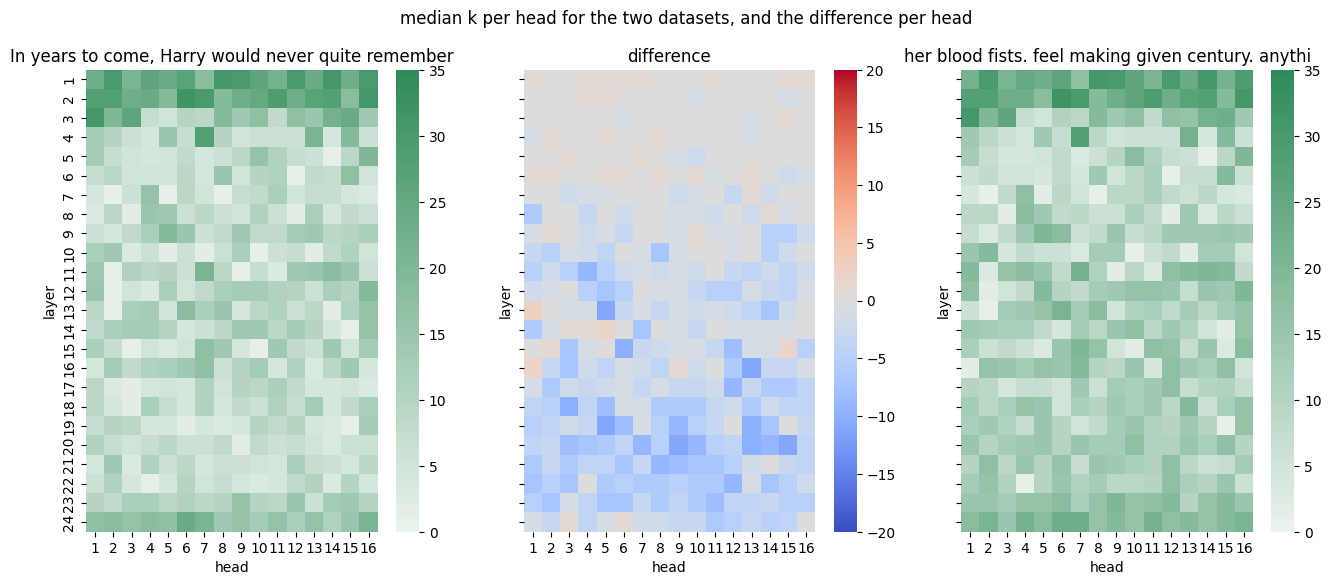

In [18]:
#@title Make median k-value plots

# fix the color/value range
anchor_cmap = False
if anchor_cmap:
  vmin = -10
  vmax = 6
else:
  vmin = None
  vmax = None

fig, axes = matplotlib.pyplot.subplots(1, 3,
              figsize=(16, 6), sharey=True)
fig.suptitle('median k per head for the two '+
             'datasets, and the difference per head')

sns.heatmap(ax=axes[0],
            data=avg_k[
                       avg_k['dataset'] == 0
                      ].pivot('layer',
                              'head',
                              "avg_k"),
            cmap=sns.light_palette("seagreen",
                               as_cmap=True),
            vmin = 0, vmax = 35
    )
axes[0].set_title(text_1[:50])

sns.heatmap(ax=axes[1],
            data=pivoted_k.pivot(['layer'],
                               'head', 'diff'),
            vmin = -20, vmax = 20,
            #vmin=vmin, vmax=vmax,
            cmap=sns.color_palette("coolwarm",
                                as_cmap=True),
        #vmin = -20, vmax = 20 #always symmetric so values at 0 are white
    )
axes[1].set_title("difference")

sns.heatmap(ax=axes[2],
            data=avg_k[
                       avg_k['dataset'] == 1
                      ].pivot('layer',
                              'head',
                              "avg_k"),
            cmap=sns.light_palette("seagreen",
                               as_cmap=True),
            vmin = 0, vmax = 35
    )
axes[2].set_title(text_2[:50])

matplotlib.pyplot.show()

In [19]:
#@title List heads with biggest median k-value differences
show_top = 384 #@param for gpt2 medium
#show_top = 144 #@param for bert-base-uncased
# diffmap = pivoted_k['diff'].values.reshape(36,20)  #for gpt2-large
diffmap = pivoted_k['diff'].values.reshape(24,16)  #for gpt2-medium
#diffmap = pivoted_k['diff'].values.reshape(12,12) #for bert-base-uncased
ranks = rankdata(-np.abs(diffmap), method='ordinal').reshape(diffmap.shape)
idx = np.argwhere(ranks <= show_top)

In [30]:
#top ten median k diff
pd.DataFrame({'layer': idx[:,0], 'head': idx[:,1],
              'median k diff': [diffmap[l,h] for l,h in idx]}
             ).sort_values(by='median k diff', key=abs, ascending=False
             ).reset_index(drop=True)

,layer,head,median k diff
0,19,14,7.080
1,10,3,6.905
2,16,11,6.813
3,11,4,6.679
4,18,4,6.400
5,9,7,6.222
6,12,4,6.220
7,14,5,5.926
8,13,0,5.872
9,15,12,5.797


In [21]:
#median k diff of all heads
scatter_mediankdiff = pd.DataFrame({'layer': idx[:,0], 'head': idx[:,1],
              'median k diff': [diffmap[l,h] for l,h in idx]}
             ).sort_values(by=['layer', 'head'], key=abs, ascending=False
             ).reset_index(drop=True)

pd.options.display.max_rows = len(scatter_mediankdiff)
print(scatter_mediankdiff)

     layer  head  median k diff
0       23    15            0.0
1       23    14           -4.0
2       23    13           -5.0
3       23    12           -3.0
4       23    11           -5.0
5       23    10           -6.0
6       23     9           -3.0
7       23     8           -3.0
8       23     7           -2.0
9       23     6           -2.0
10      23     5            1.0
11      23     4           -1.0
12      23     3           -4.0
13      23     2            1.0
14      23     1           -3.0
15      23     0           -1.0
16      22    15           -5.0
17      22    14           -5.0
18      22    13           -3.0
19      22    12           -4.0
20      22    11           -4.0
21      22    10           -8.0
22      22     9           -6.0
23      22     8           -4.0
24      22     7           -6.0
25      22     6           -3.0
26      22     5           -7.0
27      22     4           -7.0
28      22     3           -4.0
29      22     2           -1.0
30      

### Average weighted distances

In [22]:
#@title Compute average weighted distances
%%time

# select which distance function to use
func_map = {
    'weighted': lambda d, w: d * w,
    'weighted absolute': lambda d, w: np.abs(d) * w,
    'weighted square': lambda d, w: np.square(d) * w,
}
distance = "weighted square"

result = None
for i, dataset in enumerate(input_tensors):
    # create dataloader with batch size 3
    dl = get_batches(dataset, window_size, step, batch_size=3)

    data = None
    for batch, t in enumerate(dl):
        # give input to model
        input_dict = {k: v.to(device)
          for k, v in zip(["input_ids"], t)}
        output = model(**input_dict)

        # retrieve attentions
        att = np.array([a.cpu().detach().numpy()
          for a in output['attentions']])

        # swap the 'head' and 'sample' axes
        # so they're in a more natural order
        att = np.swapaxes(att, 1, 2)

        # put everything in big dataframe
        ix = create_indices(att, sample=batch*att.shape[2])
        df = create_dataframe(att, ix)
        filtered = df[
                      (df['from_token']>\
                       (window_size-(step+future))) &\
                      (df['from_token']<=\
                       (window_size-future))
                     ].copy()
        filtered['distance'] = (filtered['to_token'] -\
                                filtered['from_token'])
        filtered['sign'] = filtered['distance'] > 0
        filtered['weighted'] = func_map[distance](
            filtered['distance'],
            filtered['attention_fraction'])
        # compute mean per layer, head, sample
        g = filtered.groupby(['layer', 'head', 'sample'])
        grouped = (
            g['weighted'].agg([np.mean, 'count'])
            ).reset_index()

        if data is None:
            data = grouped
        else:
            data = pd.concat([data, grouped])

    data['dataset'] = i

    if result is None:
        result = data
    else:
        result = pd.concat([result, data])

df = result.reset_index(drop=True)

# get data ready to plot
g = df.groupby(['dataset', 'layer', 'head'])
avg_dist = (
    g['mean'].mean()
    ).reset_index(
    ).round(3)
pivoted_dist = avg_dist.pivot(
    index=['layer', 'head'],
    columns='dataset',
    values="mean").reset_index()
pivoted_dist['diff'] = pivoted_dist[0] - pivoted_dist[1] #find out which dataset is whcih
d, l, h = avg_dist['dataset'].max() + 1, \
  avg_dist['layer'].max(), \
  avg_dist['head'].max()
print(d,l,h)
sorted_avg_dist = avg_dist.sort_values(["dataset", "layer", "mean"])
sorted_avg_dist['sorted_head'] = np.tile(np.tile(np.arange(h) + 1, l), d)
# merge this sorted_head column into the original data too
data_sh = df.merge(
    sorted_avg_dist[['dataset', 'layer', 'head', 'sorted_head']],
    on=["dataset", "layer", "head"])

2 24 16
CPU times: user 12min 33s, sys: 37.6 s, total: 13min 11s
Wall time: 13min 11s


<ipython-input-23-a8ad13ab40b0>:23: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ].pivot('layer', 'head', "mean"),
<ipython-input-23-a8ad13ab40b0>:32: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  data=pivoted_dist.pivot(['layer'], 'head', 'diff'),
<ipython-input-23-a8ad13ab40b0>:43: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ].pivot('layer', 'head', "mean"),


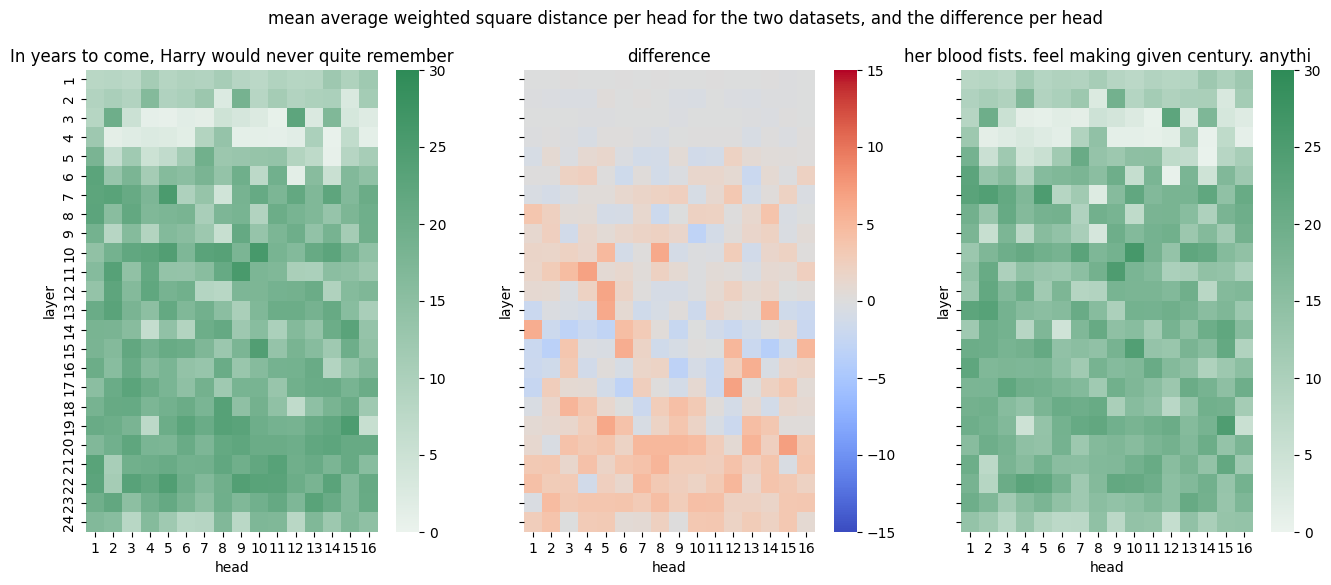

In [23]:
#@title Make average weighted distances plots

# fix the color/value range
anchor_cmap = False
if anchor_cmap:
  vmin = -10
  vmax = 6
else:
  vmin = None
  vmax = None

fig, axes = matplotlib.pyplot.subplots(1, 3,
                                       figsize=(16, 6),
                                       sharey=True)
fig.suptitle(f'mean average {distance} distance per head ' +
             'for the two datasets, and the difference ' +
             'per head')

sns.heatmap(
        ax=axes[0],
        data=avg_dist[
                      avg_dist['dataset'] == 0
                      ].pivot('layer', 'head', "mean"),
        cmap=sns.light_palette("seagreen", as_cmap=True),
        vmin = 0, vmax = 30
    )
axes[0].set_title(text_1[:50])

sns.heatmap(
        ax=axes[1],
        #vmin=vmin, vmax=vmax,
        data=pivoted_dist.pivot(['layer'], 'head', 'diff'),
        vmin = -15, vmax = 15,
        cmap=sns.color_palette("coolwarm", as_cmap=True),
        #vmin = -15, vmax = 15 #always symmetric so values at 0 are white
    )
axes[1].set_title("difference")

sns.heatmap(
        ax=axes[2],
        data=avg_dist[
                      avg_dist['dataset'] == 1
                      ].pivot('layer', 'head', "mean"),
        cmap=sns.light_palette("seagreen", as_cmap=True),
        vmin = 0, vmax = 30
    )
axes[2].set_title(text_2[:50])

matplotlib.pyplot.show()

In [24]:
#@title List heads with biggest average weighted distance differences
show_top = 384 #@param for gpt2 medium
#show_top = 144 #@param for bert-base-uncased
#diffmap = pivoted_dist['diff'].values.reshape(36,20) #for gpt2-large
diffmap = pivoted_dist['diff'].values.reshape(24,16)  #for gpt2-medium
#diffmap = pivoted_dist['diff'].values.reshape(12,12) #for bert-base-uncased
ranks = rankdata(-np.abs(diffmap), method='ordinal').reshape(diffmap.shape)
idx = np.argwhere(ranks <= show_top)

In [25]:
#top ten mean wad
pd.DataFrame({'layer': idx[:,0], 'head': idx[:,1],
              'mean wad diff': [diffmap[l,h] for l,h in idx]}
             ).sort_values(by='mean wad diff', key=abs, ascending=False
             ).reset_index(drop=True)

,layer,head,mean wad diff
0,19,14,7.080
1,10,3,6.905
2,16,11,6.813
3,11,4,6.679
4,18,4,6.400
5,9,7,6.222
6,12,4,6.220
7,14,5,5.926
8,13,0,5.872
9,15,12,5.797


In [26]:
#mean wad diff of all heads
scatter_meanwaddiff = pd.DataFrame({'layer': idx[:,0], 'head': idx[:,1],
              'mean wad diff': [diffmap[l,h] for l,h in idx]}
             ).sort_values(by=['layer', 'head'], key=abs, ascending=False
             ).reset_index(drop=True)

print(scatter_meanwaddiff)

     layer  head  mean wad diff
0       23    15          0.885
1       23    14          3.349
2       23    13          2.014
3       23    12          2.870
4       23    11          1.966
5       23    10          3.402
6       23     9          3.290
7       23     8          0.065
8       23     7          2.329
9       23     6          0.792
10      23     5          0.657
11      23     4          3.163
12      23     3          2.949
13      23     2         -0.061
14      23     1          3.853
15      23     0          2.626
16      22    15          3.459
17      22    14          3.351
18      22    13          1.647
19      22    12          2.146
20      22    11          2.161
21      22    10          4.181
22      22     9          4.230
23      22     8          2.715
24      22     7          4.352
25      22     6          2.994
26      22     5          3.740
27      22     4          3.526
28      22     3          3.626
29      22     2          3.249
30      

In [27]:
#@title List of relevant attention heads

#for 'difference' heatmap scores
##65 stands for 6.5%
st_65_k = pd.DataFrame.std(scatter_mediankdiff['median k diff']) * 1.5
st_65_wad = pd.DataFrame.std(scatter_meanwaddiff['mean wad diff']) *1.5
mean_k = pd.DataFrame.mean(scatter_mediankdiff['median k diff'])
mean_wad = pd.DataFrame.mean(scatter_meanwaddiff['mean wad diff'])

In [28]:
#dict for 'difference' heatmap scores
dict_wadk = {}
#for number in range(383): #gpt2 medium
for number in range(143): #bert-base-uncased
  if scatter_meanwaddiff['mean wad diff'][number] > (mean_wad + st_65_wad) or scatter_meanwaddiff['mean wad diff'][number] < (mean_wad - st_65_wad):
    dict_wadk[str(scatter_meanwaddiff['layer'][number]) + ' ' + str(scatter_meanwaddiff['head'][number])] = [scatter_meanwaddiff['mean wad diff'][number], scatter_mediankdiff['median k diff'][number]]
  elif scatter_mediankdiff['median k diff'][number] > (mean_k + st_65_k) or scatter_mediankdiff['median k diff'][number] < (mean_k - st_65_k):
    dict_wadk[str(scatter_mediankdiff['layer'][number]) + ' ' + str(scatter_mediankdiff['head'][number])] = [scatter_meanwaddiff['mean wad diff'][number], scatter_mediankdiff['median k diff'][number]]

print(len(dict_wadk))

dict_wadk

39


{'22 10': [4.180999999999997, -8.0],
 '22 9': [4.229999999999999, -6.0],
 '22 7': [4.352, -6.0],
 '22 5': [3.74, -7.0],
 '22 4': [3.526, -7.0],
 '22 1': [4.658999999999999, -7.0],
 '21 13': [3.8260000000000005, -7.0],
 '21 11': [5.122999999999999, -9.0],
 '21 6': [4.749999999999998, -6.0],
 '21 2': [2.9540000000000006, -7.0],
 '21 0': [4.175000000000001, -7.0],
 '20 10': [2.5649999999999977, -7.0],
 '20 9': [2.7829999999999977, -7.0],
 '20 8': [2.7070000000000007, -8.0],
 '20 7': [5.165000000000003, -9.0],
 '20 5': [3.5889999999999986, -7.0],
 '19 14': [7.080000000000002, -11.0],
 '19 13': [2.4299999999999997, -9.0],
 '19 12': [5.297999999999998, -10.0],
 '19 9': [4.633999999999999, -9.0],
 '19 8': [5.006, -11.0],
 '19 7': [5.018000000000001, -5.0],
 '19 6': [5.036000000000001, -9.0],
 '19 3': [3.2360000000000007, -7.0],
 '19 2': [3.9510000000000005, -8.0],
 '18 13': [3.4179999999999993, -7.0],
 '18 12': [4.4140000000000015, -10.0],
 '18 8': [3.5549999999999997, -9.0],
 '18 5': [3.9720

In [29]:
#@title Scatter plots

<ipython-input-31-7b4ae200236e>:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  matplotlib.pyplot.scatter(scatter_meanwaddiff['mean wad diff'], scatter_mediankdiff['median k diff'], vmin=-25, vmax=25)


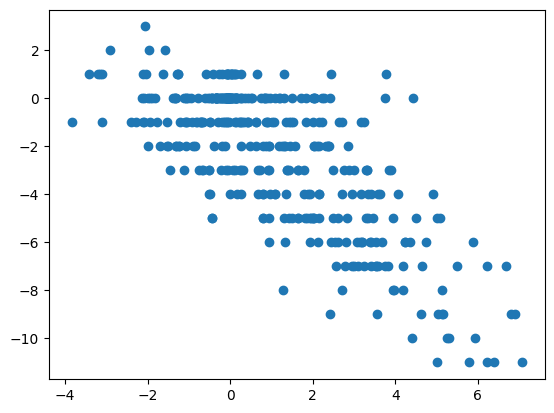

In [31]:
#'difference'
matplotlib.pyplot.scatter(scatter_meanwaddiff['mean wad diff'], scatter_mediankdiff['median k diff'], vmin=-25, vmax=25)

In [ ]:
#@title Robustness check

In [ ]:
import numpy as np
import scipy.stats as stats

# Enter the data
x = np.array([7.955,
9.034999999999998,
6.795999999999999,
7.356999999999999,
8.694999999999999,
8.418999999999999,
7.448,
-4.5440000000000005,
6.712,
-7.084,
6.635999999999999,
9.333,
6.047000000000001,
10.289,
5.946999999999999,
8.512,
5.683999999999999,
13.259,
7.758000000000001,
7.411999999999999,
-4.077999999999999,
7.909999999999998,
4.638,
10.780000000000001,
-4.897000000000002,
7.911000000000001,
8.927000000000001,
6.092000000000002,
7.228,
7.418999999999999,
8.923000000000002,
-6.660999999999998,10.057,
-7.2109999999999985,
-5.364000000000001,
-8.541,
8.096,
-7.908999999999999,
-12.429000000000002,
-6.7890000000000015,
-5.488000000000003,
-4.990000000000002,
4.1590000000000025,-3.8850000000000016,
-11.093,
-3.8069999999999986,
-5.5169999999999995,
9.209000000000001,
-9.742,
-6.920999999999999,
12.305,
7.328999999999999,
-9.158,
-9.442,
-4.438000000000002])

y = np.array([8.03,
9.181999999999999,
6.7429999999999986,
7.369999999999999,
8.774,
8.645,
7.777000000000001,
-4.804000000000002,
7.4030000000000005,
-7.142999999999997,
6.792999999999999,
9.653999999999998,
5.841999999999999,
10.589999999999998,
6.158999999999999,
8.665000000000001,
5.335000000000001,
13.708,
8.334999999999999,
7.753,
-3.884999999999998,
7.9129999999999985,
5.3100000000000005,
11.12,
-5.196999999999999,
7.852000000000002,
9.347000000000001,
6.204000000000001,
7.444000000000001,
7.854000000000001,
9.141000000000002,
-7.231000000000002,
10.492,
-7.395999999999997,
-5.129000000000001,
-9.341,
8.843,
-7.998999999999999,
-12.720999999999998,
-6.837,
-5.596999999999998,
-5.145,
4.163,
-4.062000000000001,
-11.624999999999998,
-4.029,
-5.541,
8.774000000000001,
-9.628000000000002,
-6.943999999999999,
12.372000000000002,
7.431000000000001,
-9.521999999999998,
-9.532,
-4.912000000000003])

# Calculate the Spearman rank correlation coefficient
rho, pval = stats.spearmanr(x, y)

# Display the results
print("Spearman rank correlation coefficient: ", rho)
print("p-value: ", pval)

Spearman rank correlation coefficient:  0.9957431457431459
p-value:  1.4560106988968386e-56


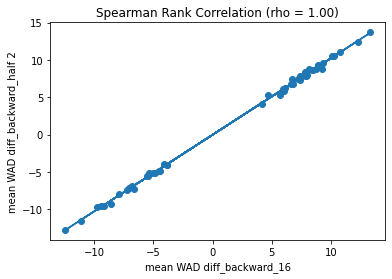

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of the data
plt.scatter(x, y)

# Add a line representing the best-fit relationship between the variables
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b)

# Add labels and a title to the plot
plt.xlabel("mean WAD diff_backward_16")
plt.ylabel("mean WAD diff_backward_half 2")
plt.title("Spearman Rank Correlation (rho = {:.2f})".format(rho))

# Show the plot
plt.show()